In [166]:
import pandas as pd
pd.set_option('mode.chained_assignment', None)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
from tqdm.notebook import tqdm
from data_processing.utils.download_functions import *
from copy import deepcopy

from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

os.chdir('esports-data')
os.listdir()

In [613]:
class DataAggregator:
    """
    Class to aggregate the data from the different years into one dataframe
    """
    def __init__(self):
        # SET CONSTANTS FOR DATA PROCESSING
        self._window_size = 20
        self._ewm_alpha = 0.05
        self._ma_min_periods = 1

        self.league_indicators_to_drop = ['League_TFT Rising Legends', 'League_All-Star Event', 'League_MSI', 'League_Worlds', 'League_EMEA Masters']
        self.non_game_features = ['platformGameId', 'esportsGameId', 'team_id', 'start_time', 'tournament_name']
        self.league_indicators = ['League_Arabian League','League_CBLOL','League_CBLOL Academy','League_College Championship','League_Elite Series','League_Esports Balkan League',
                         'League_Greek Legends League','League_Hitpoint Masters','League_LCK','League_LCK Academy','League_LCK Challengers','League_LCL','League_LCO','League_LCS',
                         'League_LCS Challengers','League_LCS Challengers Qualifiers','League_LEC','League_LJL','League_LJL Academy','League_LLA','League_LPL','League_La Ligue FranÃ§aise',
                         'League_Liga Portuguesa','League_NLC','League_North Regional League','League_PCS','League_PG Nationals','League_Prime League',
                         'League_South Regional League','League_SuperLiga','League_TCL','League_Ultraliga','League_VCS']
        # Include a set of features that are known to be important for the model 
        self.mandatory_features = ['outcome', 'outcome_domestic', 'outcome_international', 'domestic_game_ind', 
                                   'eSportsLeague_1', 'eSportsLeague_2', 'eliteLeague_1', 'eliteLeague_2', 'majorLeague_1', 'majorLeague_2', 'year']
        # Mark special features that require a different style of processing 
        self.special_features = ['outcome_domestic', 'outcome_international']
        
        # Maintain a manual dictionary of team_id to league_indicator. This is necessary to mark the regions for teams in international tournaments (MSI/worlds since LPL teams don't have data)
        # Loop through this and mark the league_indicator for each team_id as =1 for the rows where the team_id is present
        self.league_indicator_dict = {
            98767991954244555: 'League_VCS', # GAM
            107251245690956393: 'League_VCS', # SAIGON BUFFALOS
            98767991892579754: 'League_LPL',  # RNG
            104367068120825486: 'League_PCS',  # PSG Talon
            98767991882270868: 'League_LPL',  # EDG
            99566404850008779: 'League_LPL',  # LNG
            99566404855553726: 'League_LPL',  # FPX
            99566404852189289: 'League_LPL',  # JDG
            99566404854685458: 'League_LPL',  # TES
            105520788833075738: 'League_Elite Series', # KV Mechelen
            105520824521753126: 'League_NLC', # PSV Esports
            105543843212923183: 'League_Ultraliga', # Goskilla
            105548000936710641: 'League_Ultraliga', # Method2Madness
            103935642731826448: 'League_Elite Series', # Sector One
            104710682193583854: 'League_Ultraliga', # Topo Centras Iron Wolves
            105520822049210915: 'League_Elite Series', # Team mCon
            106334794714373670: 'League_Ultraliga', # Goexanimo
        }
        
        # Read in teams data
        with open("teams.json", "r") as json_file:
           teams_data = json.load(json_file)
        teams_dict = {}
        for team in teams_data:
            teams_dict[team['team_id']] = team['name']
        self.teams_dict = teams_dict
        
    def get_featurized_data(self, folder_paths, years):
        """
        We do the following steps to process the game data
        1) Read in the tournament rows data, which specifies the match ID, the participating teams, and the winner of the match 
        2) Read in the game rows data, which contains all the granular information about each game 
        3) Additionally process the game rows data
            i) Sort the game rows by team_id and start_time
            ii) Create features based on the stats of the team over historical games 
            iii) Handle the league region indicators for each time (as 'eSportLeague')
            iv) 
        :param folder_paths: list of strings specifying the folder paths
        :param years: list of strings specifying the years 
        :return: 
            model_data - dataframe containing the diff between the two teams for each game used for training
            processed_game_data - dataframe containing the processed game data for each individual team used for inference
        """
        tournament_rows = pd.DataFrame()
        game_rows = pd.DataFrame()
        for (folder_path, year) in zip(folder_paths, years):
            file_names = os.listdir(folder_path)

            # Get the unique tournament names by stripping out '_game_rows.csv' and '_tournament_rows.csv'
            unique_tournament_names = [file_name.split('_game_rows.csv')[0] for file_name in file_names]
            unique_tournament_names = [x.replace('_tournament_rows.csv', '') for x in unique_tournament_names]
            unique_tournament_names = list(set(unique_tournament_names))

            # Aggregate all the game rows into one dataframe, start with an empty dataframe and append onto it to save memory
            
            for tournament_name in tqdm(unique_tournament_names):
                df_tmp = pd.read_csv(f'{folder_path}/' + tournament_name + '_tournament_rows.csv')
                # Add a column to indicate the tournament name
                df_tmp['tournament_name'] = tournament_name
                tournament_rows = pd.concat([tournament_rows, df_tmp])
            print("Tournament rows shape: ", tournament_rows.shape)

            
            for tournament_name in tqdm(unique_tournament_names):
                df_tmp = pd.read_csv(f'{folder_path}/' + tournament_name + '_game_rows.csv', index_col=0)
                # Add a column to indicate the tournament name
                df_tmp['tournament_name'] = tournament_name
                df_tmp['year'] = year
                game_rows = pd.concat([game_rows, df_tmp])
            print("Game rows shape: ", game_rows.shape)

        print("Completed data loading")
        print("Tourament rows shape: ", tournament_rows.shape)
        print("Game rows shape: ", game_rows.shape)

        game_rows = game_rows.drop(columns=self.league_indicators_to_drop, axis=1)
        game_features = [x for x in game_rows.columns if x not in self.non_game_features + self.league_indicators + self.special_features + ['year']]
        self.game_features = game_features
        
        # Get a set of all team IDs as we will iterate through them to generate the row data for each team 
        all_team_ids = np.unique(game_rows['team_id'])
        processed_game_data = self.featurize_game_rows(game_rows, all_team_ids)
        del game_rows
        processed_game_data = self.refine_league_indicator_data(processed_game_data)


        valid_games = self.get_valid_game_rows(tournament_rows, processed_game_data)
        model_data = self.get_model_data(valid_games, processed_game_data)
        return model_data, processed_game_data
    
    def featurize_game_rows(self, game_rows, all_team_ids, averaging_method='ewm'):
        """
        averaging_method must be either 'ewm' or 'mean'
        """
        processed_game_data = []
        for team in tqdm(all_team_ids):
            team_data = game_rows[game_rows['team_id']==team].reset_index()
            team_data = team_data.sort_values(by=['start_time'])
            team_data['num_prev_games'] = np.arange(len(team_data))
            team_data['outcome_domestic'] = np.nan
            team_data['outcome_international'] = np.nan
            # Set outcome_international for worlds and msi tournaments
            team_data.loc[team_data['tournament_name'].str.contains('worlds|msi'), 'outcome_international'] = team_data['outcome']
            # Set outcome_domestic for non-worlds and non-msi tournaments
            team_data.loc[~team_data['tournament_name'].str.contains('worlds|msi'), 'outcome_domestic'] = team_data['outcome']
            
            # First lag by 1 game so that the current game is not included in the average. Then take the mean as the trailing average 
            if averaging_method == 'ewm':
                team_data_features = team_data[self.game_features + self.special_features].shift(1).ewm(alpha=self._ewm_alpha, min_periods=self._ma_min_periods, ignore_na=True).mean()
            elif averaging_method == 'mean':
                team_data_features = team_data[self.game_features + self.special_features].shift(1).rolling(window=self._window_size, min_periods=1).mean()
            else:
                raise ValueError('averaging_method must be either "ewm" or "mean"')
            team_data[self.game_features + self.special_features] = team_data_features
            # Drop rows where num_prev_games == 0 as this indicates that it's the team's first game 
            team_data = team_data[team_data['num_prev_games']!=0]
        
            # Add the team name to the dataframe
            try:
                team_name = self.teams_dict[str(team)]
            except KeyError:
                team_name = "NULL"
            # Add a column for the team name
            team_data['team_name'] = team_name
        
            # Determine the team's primary league
            team_league = team_data[self.league_indicators].mean(axis=0).idxmax()
            # Determine if it's a valid league (otherwise it'll just mark the first one)
            team_league_check = team_data[team_league].sum() > 0 # If false, then do not mark based on history, have to manually mark 
            
            # check if there are any rows where the team does not have a league_indicator (i.e., np.sum(team_data[league_indicators]) == 0) and if so, mark the team_league as 1 for those rows
            # This happens when a team plays in international tournaments 
            if team_league_check:
                team_data.loc[np.sum(team_data[self.league_indicators], axis=1)==0, team_league] = 1
            else:
                pass
        
            # update the processed_game_data with the new league_indicator values
            processed_game_data.append(team_data)
        
        del game_rows  # Don't need this anymore once we're done processing them
        
        processed_game_data = pd.concat(processed_game_data)
        processed_game_data.drop('index', axis=1, inplace=True)
        return processed_game_data
    
    def refine_league_indicator_data(self, processed_game_data):
        # Next deal with marking specific team's leagues 
        for team_id, league_indicator in self.league_indicator_dict.items():
            processed_game_data.loc[processed_game_data['team_id']==team_id, league_indicator] = 1
            
        # Create two additional features related to the esport league
        # If the team is an LPL or LCK team, mark indicator 'eliteLeague' as 1
        # If the team is an LEC, LCS, LPL, or LCK team, mark indicator 'majorLeague' as 1
        processed_game_data['eliteLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1)
        processed_game_data['majorLeague'] = (processed_game_data['League_LPL'] == 1) | (processed_game_data['League_LCK'] == 1) | \
                                             (processed_game_data['League_LCS'] == 1) | (processed_game_data['League_LEC'] == 1)
        
        # Check that the one-hot encoding worked correctly
        if (np.sum(processed_game_data[self.league_indicators], axis=1) == 1).all():
            # Convert the league_indicator one-hot encoded columns to categorical variables
            for league in [x.replace('League_', '') for x in self.league_indicators]:
                processed_game_data['League_' + league] = processed_game_data['League_' + league].apply(lambda x: league if x==1 else '')
            # Combine it into a single column
            processed_game_data['eSportLeague'] = processed_game_data[self.league_indicators].apply(lambda x: ''.join(x), axis=1)
            processed_game_data = processed_game_data.drop(columns=self.league_indicators, axis=1)
            # Convert it to a categorical variable
            processed_game_data['eSportLeague'] = processed_game_data['eSportLeague'].astype('category')
        else:
            raise ValueError('One-hot encoding of league_indicators did not work correctly')
        return processed_game_data
        
    def get_valid_game_rows(self, tournament_rows, processed_game_data):
        valid_games = tournament_rows.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                    left_on=['esportsGameId', 'team_id_1'], 
                                    right_on=['esportsGameId', 'team_id'], 
                                    suffixes=['_to_drop','_to_drop'])
        valid_games = valid_games.merge(processed_game_data[['esportsGameId', 'team_id']], how='inner', 
                                            left_on=['esportsGameId', 'team_id_2'], 
                                            right_on=['esportsGameId', 'team_id'],
                                            suffixes=['_to_drop','_to_drop'])
        valid_games.drop([x for x in valid_games.columns if '_to_drop' in x], axis=1, inplace=True)
        return valid_games 
        
    def get_model_data(self, valid_games, processed_game_data):
        # Merge processed_game_data with tournament_rows for team 1
        team_1_data = valid_games.merge(processed_game_data, how='inner', 
                                            left_on=['esportsGameId', 'team_id_1'], 
                                            right_on=['esportsGameId', 'team_id'],
                                            suffixes=['_to_drop','_to_drop'])
        
        # Merge processed_game_data with tournament_rows for team 2
        team_2_data = valid_games.merge(processed_game_data, how='inner', 
                                            left_on=['esportsGameId', 'team_id_2'], 
                                            right_on=['esportsGameId', 'team_id'],
                                            suffixes=['_to_drop','_to_drop'])
        
        # Calculate the difference between the two teams for esportsGameId and for each feature
        check_esportsGameId = np.all(team_1_data['esportsGameId'] == team_2_data['esportsGameId'])
        check_team1_id = np.all(team_1_data['team_id_1'] == team_2_data['team_id_1'])
        check_team2_id = np.all(team_1_data['team_id_2'] == team_2_data['team_id_2'])
        
        if check_esportsGameId and check_team1_id and check_team2_id:
            # Calculate the difference between the two teams for each feature
            difference_data = team_1_data[self.game_features].subtract(team_2_data[self.game_features])
            # Apply special logic for computing the difference for the "outcome_domestic" and "outcome_international" features 
            for feature in self.special_features:
                # Calculate the difference between columns A and B
                diff = team_1_data[feature].fillna(0).sub(team_2_data[feature].fillna(0)) 
                # If both columns are nan then mark the difference as nan
                diff[(team_1_data[feature].isna()) & (team_2_data[feature].isna())] = np.nan
                difference_data[feature] = diff
        else:
            raise Exception('esportsGameId is not the same for the two teams')
        
        # Add the difference data to the tournament_rows dataframe as well as the league data for each team
        training_data = deepcopy(valid_games)
        training_data = pd.concat([training_data.reset_index(), difference_data], axis=1)
        training_data['eSportsLeague_1'] = team_1_data['eSportLeague']
        training_data['eSportsLeague_2'] = team_2_data['eSportLeague']
        training_data['domestic_game_ind'] = training_data['eSportsLeague_1'] == training_data['eSportsLeague_2'] 
        training_data['eliteLeague_1'] = team_1_data['eliteLeague']
        training_data['eliteLeague_2'] = team_2_data['eliteLeague']
        training_data['majorLeague_1'] = team_1_data['majorLeague']
        training_data['majorLeague_2'] = team_2_data['majorLeague']
        training_data['team_1'] = team_1_data['team_name']
        training_data['team_2'] = team_2_data['team_name']
        training_data['start_time'] = team_1_data['start_time']
        training_data['year'] = team_1_data['year']
        
        # Drop the columns that were used for joining (have '_to_drop' suffix). 
        training_data.drop([x for x in training_data.columns if '_to_drop' in x] + ['index'], axis=1, inplace=True)
        
        # drop the games where the outcome is NaN, those games are when one team has not had any games yet
        training_data.dropna(subset=['outcome'], inplace=True)
        
        del team_1_data, team_2_data, difference_data
        return training_data

In [601]:
data_aggregator = DataAggregator()
model_data, game_data = data_aggregator.get_featurized_data(['2021_raw_game_data', '2022_raw_game_data', '2023_raw_game_data'] ,['2021', '2022', '2023'])

  0%|          | 0/51 [00:00<?, ?it/s]

Tournament rows shape:  (4990, 8)


  0%|          | 0/51 [00:00<?, ?it/s]

Game rows shape:  (9574, 1244)


  0%|          | 0/56 [00:00<?, ?it/s]

Tournament rows shape:  (10674, 8)


  0%|          | 0/56 [00:00<?, ?it/s]

Game rows shape:  (20638, 1244)


  0%|          | 0/65 [00:00<?, ?it/s]

Tournament rows shape:  (17599, 8)


  0%|          | 0/65 [00:00<?, ?it/s]

Game rows shape:  (34254, 1244)
Completed data loading
tourn


  0%|          | 0/450 [00:00<?, ?it/s]

In [602]:
# data_aggregator = DataAggregator()
# model_data_2021, team_data_2021 = data_aggregator.get_featurized_data('2021_raw_game_data', '2021')
# model_data_2022, team_data_2022 = data_aggregator.get_featurized_data('2022_raw_game_data', '2022')
# model_data_2023, team_data_2023 = data_aggregator.get_featurized_data('2023_raw_game_data', '2023')

# model_data = pd.concat([model_data_2021, model_data_2022, model_data_2023])
# game_data = pd.concat([team_data_2021, team_data_2022, team_data_2023])
# del model_data_2021, model_data_2022, model_data_2023
# del team_data_2021, team_data_2022, team_data_2023
# print(model_data.shape)
# print(game_data.shape)

In [616]:
# Check the heterogeneity of the outcome diff based on the team_1 alone
model_data.groupby('team_1')['outcome'].mean().sort_values(ascending=False)

team_1
Horizon Gaming               1.000000
Team E Turner                0.621588
Primate                      0.364307
T1 Rookies                   0.351397
7more7 Pompa Team            0.341073
                               ...   
Conviction                  -0.512821
The Last Dance              -0.544761
St. Clair College           -0.585572
Goexanimo                   -0.684964
Michigan State University   -1.000000
Name: outcome, Length: 435, dtype: float64

In [617]:
sample_data = game_data[game_data['team_name']=='100 Thieves'].copy(deep=True).reset_index()

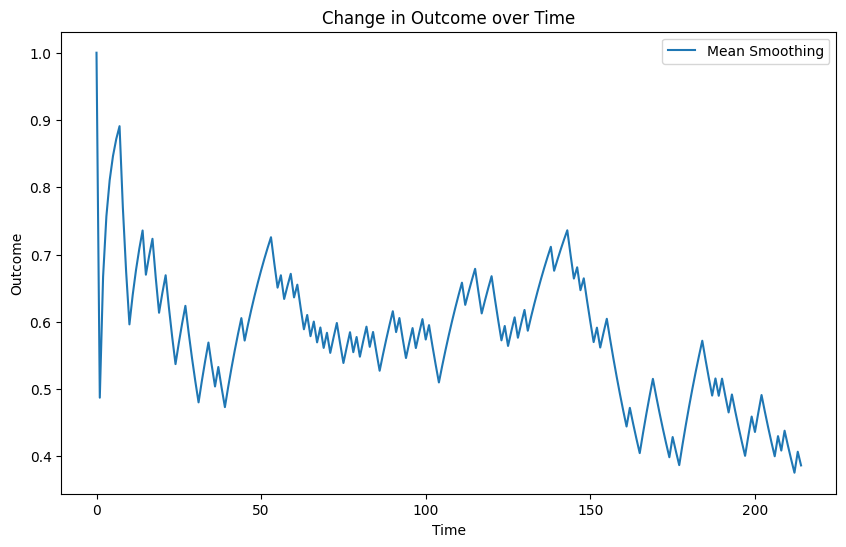

In [618]:
import matplotlib.pyplot as plt

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the 'outcome' column using the plain mean() smoothing
sample_data['outcome'].plot(ax=ax, label='Mean Smoothing')
# sample_data['outcome_domestic'].ewm(alpha=0.2).mean().plot(ax=ax, label='Mean Smoothing')

# Plot the 'outcome' column using the ewm() exponential moving average
# sample_data['outcome'].plot(ax=ax, label='Exponential Moving Average overall')

# Set the title and axis labels
ax.set_title('Change in Outcome over Time')
ax.set_xlabel('Time')
ax.set_ylabel('Outcome')

# Add a legend
ax.legend()

# Show the plot
plt.show()

In [619]:
# The problem is that we first smooth, then concatenate. Really, we should be concatenating, then smoothing 
sample_data[sample_data['tournament_name']=='lcs_summer_2022'][['platformGameId', 'tournament_name', 'start_time', 'outcome', 'outcome_domestic', 'outcome_international', 'team_name']]

,platformGameId,tournament_name,start_time,outcome,outcome_domestic,outcome_international,team_name
123,ESPORTSTMNT03:2790941,lcs_summer_2022,2022-06-17 23:51:14.610,0.572395,0.575514,0.521786,100 Thieves
124,ESPORTSTMNT03:2781702,lcs_summer_2022,2022-06-18 22:45:13.575,0.593811,0.596786,0.521786,100 Thieves
125,ESPORTSTMNT03:2782165,lcs_summer_2022,2022-06-19 19:39:27.407,0.564074,0.566883,0.521786,100 Thieves
126,ESPORTSTMNT03:2796826,lcs_summer_2022,2022-06-25 21:41:48.776,0.585902,0.588582,0.521786,100 Thieves
127,ESPORTSTMNT03:2797606,lcs_summer_2022,2022-06-26 21:41:07.178,0.606636,0.609193,0.521786,100 Thieves
128,ESPORTSTMNT04:2410530,lcs_summer_2022,2022-07-02 22:22:50.915,0.576264,0.578678,0.521786,100 Thieves
129,ESPORTSTMNT04:2430766,lcs_summer_2022,2022-07-03 23:16:36.065,0.597478,0.599780,0.521786,100 Thieves
130,ESPORTSTMNT05:2942670,lcs_summer_2022,2022-07-16 20:31:20.935,0.617628,0.619824,0.521786,100 Thieves
131,ESPORTSTMNT05:2943023,lcs_summer_2022,2022-07-17 20:35:12.186,0.586711,0.588784,0.521786,100 Thieves
132,ESPORTSTMNT06:2540485,lcs_summer_2022,2022-07-23 22:51:59.839,0.607398,0.609376,0.521786,100 Thieves


In [338]:
sample_data[sample_data['tournament_name']=='worlds_2022'][['platformGameId', 'tournament_name', 'start_time', 'outcome', 'outcome_domestic', 'outcome_international', 'team_name']]

,platformGameId,tournament_name,start_time,outcome,outcome_domestic,outcome_international,team_name


In [620]:
sample_data[['platformGameId', 'tournament_name', 'start_time', 'outcome', 'outcome_domestic', 'outcome_international', 'team_name']].iloc[150:180]

,platformGameId,tournament_name,start_time,outcome,outcome_domestic,outcome_international,team_name
150,ESPORTSTMNT02:2965231,lcs_summer_2022,2022-09-10 20:23:56.247,0.599797,0.600581,0.521786,100 Thieves
151,ESPORTSTMNT02:2965252,lcs_summer_2022,2022-09-10 21:24:06.719,0.569795,0.570535,0.521786,100 Thieves
152,ESPORTSTMNT02:2965253,lcs_summer_2022,2022-09-10 22:16:02.691,0.591314,0.592020,0.521786,100 Thieves
153,ESPORTSTMNT02:2965254,lcs_summer_2022,2022-09-10 23:11:52.184,0.561737,0.562404,0.521786,100 Thieves
154,ESPORTSTMNT02:2965255,lcs_summer_2022,2022-09-11 00:07:20.058,0.583658,0.584294,0.521786,100 Thieves
155,ESPORTSTMNT02:2965292,lcs_summer_2022,2022-09-11 20:16:44.647,0.604482,0.605089,0.521786,100 Thieves
156,ESPORTSTMNT02:2965320,lcs_summer_2022,2022-09-11 21:08:34.633,0.574248,0.574821,0.521786,100 Thieves
157,ESPORTSTMNT02:2965321,lcs_summer_2022,2022-09-11 21:54:07.850,0.545527,0.546068,0.521786,100 Thieves
158,ESPORTSTMNT02:3045196,worlds_2022,2022-10-07 23:22:30.317,0.518243,0.518754,0.521786,100 Thieves
159,ESPORTSTMNT02:3045853,worlds_2022,2022-10-09 22:18:01.620,0.492324,0.518754,0.435301,100 Thieves


In [7]:
# Do catboost on the training data
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.model_selection import GridSearchCV

target_col = 'outcome_1'
## At this point could assign row weights based on 'tournament_name' column to upweight/downweight certain tournaments
X = model_data.drop(['match_id', 'esportsGameId', 'league', 'team_id_1', 'outcome_1', 'team_id_2', 'outcome_2'], axis=1)
y = model_data[target_col]

# Split into train/val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=20)

# Get all indices where X_train['tournment_name'] contains ['worlds', 'msi'] 
international_ix_train = X_train['tournament_name'].str.contains('worlds|msi')
international_ix_test = X_test['tournament_name'].str.contains('worlds|msi')

# Create a weight vector where the international games are weighted 2x
weights_train = np.ones(len(X_train))
weights_train[international_ix_train] = 5

X_train = X_train.drop('tournament_name', axis=1)
train_data = Pool(data=X_train, label=y_train, weight=weights_train, cat_features=['eSportsLeague_1', 'eSportsLeague_2'])
X_val = X_val.drop('tournament_name', axis=1)
val_data = Pool(data=X_val, label=y_val, cat_features=['eSportsLeague_1', 'eSportsLeague_2'])
X_test = X_test.drop('tournament_name', axis=1)

CatBoostError: Bad value for num_feature[non_default_doc_idx=0,feature_idx=1206]="Primate": Cannot convert 'b'Primate'' to float

In [12]:
# First do some feature selection on X_train using catboost algorithms, use default parameters  
from catboost import EShapCalcType, EFeaturesSelectionAlgorithm
# 'iterations': 10, 'learning_rate': 0.051497919752583575, 'depth': 10, 'min_data_in_leaf': 24, 'l2_leaf_reg': 5, 'random_strength': 1.5
model = CatBoostClassifier(iterations=10, learning_rate=0.05, depth=10, l2_leaf_reg=5, random_strength= 1.5, task_type="GPU", devices='0:1', silent=True)
summary = model.select_features(
        train_data,
        eval_set=val_data,
        features_for_select=list(range(X_train.shape[1])),     # we will select from all features
        num_features_to_select=200, 
        steps=1,                                     # more steps - more accurate selection
        algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
        shap_calc_type=EShapCalcType.Approximate,            # can be Approximate, Regular and Exact
        train_final_model=True,                          # to train model with selected features
        logging_level='Verbose',
        plot=False
)

Step #1 out of 1
bestTest = 0.6677589044
bestIteration = 9
Feature #616 eliminated
Feature #522 eliminated
Feature #319 eliminated
Feature #1149 eliminated
Feature #325 eliminated
Feature #1079 eliminated
Feature #295 eliminated
Feature #96 eliminated
Feature #392 eliminated
Feature #767 eliminated
Feature #519 eliminated
Feature #1120 eliminated
Feature #451 eliminated
Feature #1086 eliminated
Feature #0 eliminated
Feature #2 eliminated
Feature #3 eliminated
Feature #4 eliminated
Feature #5 eliminated
Feature #6 eliminated
Feature #7 eliminated
Feature #8 eliminated
Feature #9 eliminated
Feature #10 eliminated
Feature #11 eliminated
Feature #12 eliminated
Feature #13 eliminated
Feature #14 eliminated
Feature #15 eliminated
Feature #16 eliminated
Feature #17 eliminated
Feature #18 eliminated
Feature #19 eliminated
Feature #20 eliminated
Feature #21 eliminated
Feature #22 eliminated
Feature #23 eliminated
Feature #24 eliminated
Feature #25 eliminated
Feature #26 eliminated
Feature #27 e

In [61]:
# Save list a to a list
import pickle

# with open("selected_features_RSV_Approx_200.txt", "wb") as fp:   #Pickling
#     pickle.dump(summary['selected_features_names'], fp)
    
# Read in the selected features as a list
with open("selected_features_RSV_Approx_200.txt", "rb") as fp:   # Unpickling
    selected_features = pickle.load(fp)

In [621]:
# Make sure that important features are in selected_features and if not, add them
# Do this by taking the union of the selected features and the mandatory features
model_features = list(set(selected_features + data_aggregator.mandatory_features + data_aggregator.special_features)) + ['team_1', 'team_2']

target_col = 'outcome_1'
X = model_data.drop(['match_id', 'esportsGameId', 'league', 'team_id_1', 'outcome_1', 'team_id_2', 'outcome_2'], axis=1)
y = model_data[target_col]

# Split into train/val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=110)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=22)

# Get all indices where X_train['tournment_name'] contains ['worlds', 'msi'] 
international_ix_train = X_train['tournament_name'].str.contains('worlds|msi')
international_ix_test = X_test['tournament_name'].str.contains('worlds|msi')

# Create a weight vector where the international games are weighted 2x
weights_train = np.ones(len(X_train))
weights_train[international_ix_train] = 50

X_train = X_train.drop('tournament_name', axis=1)
X_train = X_train[model_features]
train_data = Pool(data=X_train, label=y_train, weight=weights_train, cat_features=['eSportsLeague_1', 'eSportsLeague_2', 'team_1', 'team_2'])
X_val = X_val.drop('tournament_name', axis=1)
X_val = X_val[model_features]
val_data = Pool(data=X_val, label=y_val, cat_features=['eSportsLeague_1', 'eSportsLeague_2', 'team_1', 'team_2'])
X_test = X_test.drop('tournament_name', axis=1)
X_test = X_test[model_features]

In [622]:
# Hyperparameter tuning

import optuna
def objective(trial):
    params = {
        "iterations": trial.suggest_categorical("iterations", [10, 15, 25, 50, 100, 200]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "depth": trial.suggest_int("depth", 5, 10),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 30),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 30),
        "random_strength": trial.suggest_categorical("random_strength", [0.5, 1, 1.5, 2, 3, 4])
    }

    model = CatBoostClassifier(**params, cat_features=['eSportsLeague_1', 'eSportsLeague_2', 'team_1', 'team_2'], task_type="GPU", devices='0:1', silent=True)
    model.fit(train_data)
    predictions = model.predict(X_val)
    accuracy = accuracy_score(y_val, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

[I 2023-10-03 22:31:48,554] A new study created in memory with name: no-name-95b74f38-d382-4836-b0e9-f82b9aa7ac2e
[I 2023-10-03 22:31:50,448] Trial 0 finished with value: 0.6329866270430906 and parameters: {'iterations': 50, 'learning_rate': 0.005808004760191895, 'depth': 5, 'min_data_in_leaf': 10, 'l2_leaf_reg': 6, 'random_strength': 0.5}. Best is trial 0 with value: 0.6329866270430906.
[I 2023-10-03 22:31:52,390] Trial 1 finished with value: 0.62481426448737 and parameters: {'iterations': 15, 'learning_rate': 0.1893789704739625, 'depth': 8, 'min_data_in_leaf': 12, 'l2_leaf_reg': 5, 'random_strength': 2}. Best is trial 0 with value: 0.6329866270430906.
[I 2023-10-03 22:31:54,209] Trial 2 finished with value: 0.6419019316493314 and parameters: {'iterations': 15, 'learning_rate': 0.01540223146620121, 'depth': 6, 'min_data_in_leaf': 9, 'l2_leaf_reg': 19, 'random_strength': 3}. Best is trial 2 with value: 0.6419019316493314.
[I 2023-10-03 22:32:02,105] Trial 3 finished with value: 0.61738

In [625]:
# Print the best parameters and fit a new model on the data based on it

# 'iterations': 15, 'learning_rate': 0.18987819258877012, 'depth': 5, 'min_data_in_leaf': 11, 'l2_leaf_reg': 21, 'random_strength': 3

print(study.best_params)
model = CatBoostClassifier(**study.best_params, cat_features=['eSportsLeague_1', 'eSportsLeague_2', 'team_1', 'team_2'], task_type="GPU", devices='0:1', silent=True)
model.fit(X_train, y_train)

{'iterations': 15, 'learning_rate': 0.01540223146620121, 'depth': 6, 'min_data_in_leaf': 9, 'l2_leaf_reg': 19, 'random_strength': 3}


In [626]:
yhat_train_model = np.round(model.predict(X_train))
yhat_train_base = (X_train['outcome_domestic'] >= 0)

yhat_test_model = np.round(model.predict(X_test))
yhat_test_base = (X_test['outcome_domestic'] >= 0)

In [627]:
 # TRAINING DATA
print("TRAINING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_train, yhat_train_model)}")
print(f"Accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_model[international_ix_train])}")
print(f"Accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_model[~international_ix_train])}")

print()

# Evaluate the accuracy for the baseline
print(f"Baseline accuracy overall: {accuracy_score(y_train, yhat_train_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_train[international_ix_train], yhat_train_base[international_ix_train])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_train[~international_ix_train], yhat_train_base[~international_ix_train])}")

# TESTING DATA 
print("\n TESTING DATA")
# Evaluate the accuracy overall, for international games, and for domestic games separately
print(f"Accuracy overall: {accuracy_score(y_test, yhat_test_model)}")
print(f"Accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_model[international_ix_test])}")
print(f"Accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_model[~international_ix_test])}")

print()

# Evaluate the accuracy for the baseline 
print(f"Baseline accuracy overall: {accuracy_score(y_test, yhat_test_base)}")
print(f"Baseline accuracy international: {accuracy_score(y_test[international_ix_test], yhat_test_base[international_ix_test])}")
print(f"Baseline accuracy domestic: {accuracy_score(y_test[~international_ix_test], yhat_test_base[~international_ix_test])}")

TRAINING DATA
Accuracy overall: 0.6369416233176451
Accuracy international: 0.6073619631901841
Accuracy domestic: 0.6377598642341961

Baseline accuracy overall: 0.6126661712492775
Baseline accuracy international: 0.401840490797546
Baseline accuracy domestic: 0.6184980907933815

 TESTING DATA
Accuracy overall: 0.6309063893016345
Accuracy international: 0.7156862745098039
Accuracy domestic: 0.628256205945449

Baseline accuracy overall: 0.6109955423476969
Baseline accuracy international: 0.47058823529411764
Baseline accuracy domestic: 0.6153846153846154


In [628]:
# Check the feature importance of the model
pd.DataFrame({x: y for x, y in zip(X_train.columns, model.get_feature_importance())}, index = [0]).T.sort_values(by=0, ascending=False)

,0
team_share_of_towerKills_at_game_end,19.760470
team_share_of_totalGold_at_game_end,17.300270
team_share_of_VISION_SCORE_at_game_end,5.942261
bot_xp_per_min_diff_at_game_end,4.766271
bot_lane_damage_to_buildings_dominance_at_game_end,4.556277
...,...
top_damage_to_champions_per_min_diff_at_20,0.000000
bot_share_of_team_xp_at_20,0.000000
jungle_MINIONS_KILLED_at_30,0.000000
support_share_of_team_damage_to_buildings_at_20,0.000000


In [629]:
# Get shapley values for the first prediction just to test the functionality 
import shap
shap.initjs()

In [630]:
import fasttreeshap
shap_explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)
shap_values = shap_explainer(X_test)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


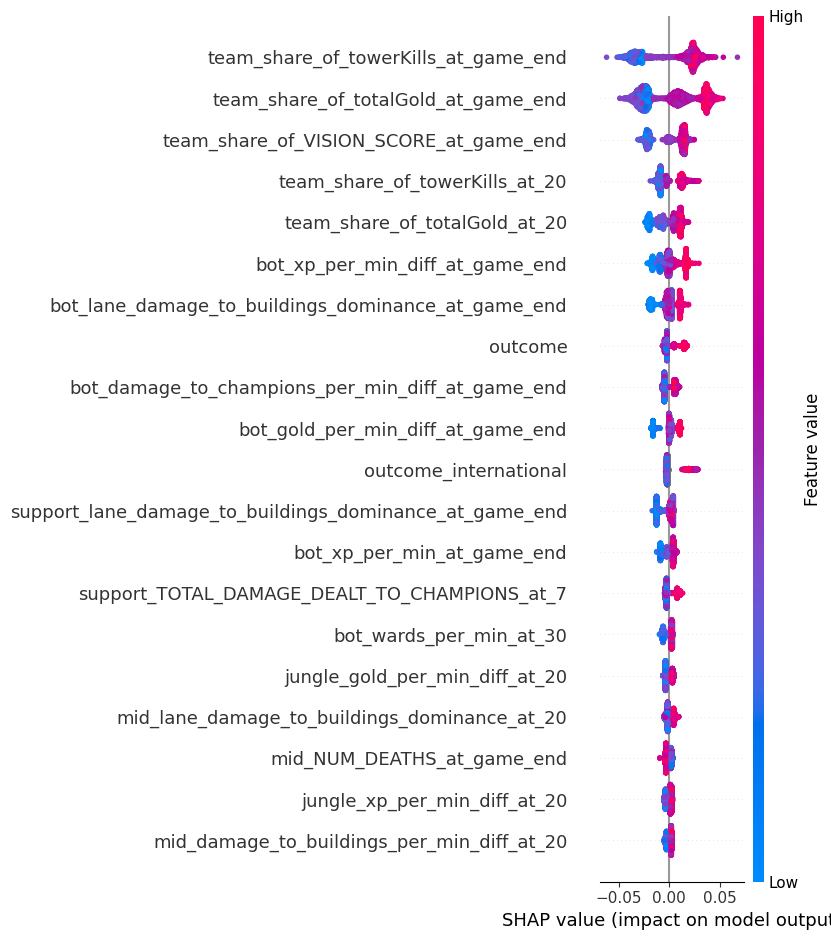

In [631]:
shap.summary_plot(shap_values, X_test)

In [651]:
# Run the model on a specific game 

tournament_data = model_data[model_data['tournament_name']=='lcs_spring_2023']

In [634]:
from difflib import SequenceMatcher

def find_closest_key(string, dictionary):
    closest_key = None
    closest_distance = 0
    
    for key in dictionary.keys():
        distance = SequenceMatcher(None, string, key).ratio()
        if distance > closest_distance:
            closest_key = key
            closest_distance = distance
    print(closest_key)
    return dictionary[closest_key]

In [635]:
teams_dict_rev = {v:k for (k,v) in data_aggregator.teams_dict.items()}

In [636]:
worlds_teams = ['Gen.G', 'T1', 'KT Rolster', 'Dplus', 'Cloud9', 'NRG', 'Team Liquid', 'Beijing JDG Intel', 'bilibili', 'suzhou LNG',
    'g2 esports', 'fnatic', 'MAD lions', 'golden guardians', 'team BDS', 'LOUD', 'GAM esports', 'TEAM WHALES', 'psg talon', 'ctbc flying oyster', 'detonation focusme', 
    'Movistar R7']

worlds_team_ids = [int(find_closest_key(x, teams_dict_rev)) for x in worlds_teams]

Gen.G
T1
kt Rolster
Dplus Kia
Cloud9
NRG
Team Liquid Honda
Beijing JDG Intel Esports Club
Bilibili Gaming Pingan Bank
Suzhou LNG Esports
G2 Esports
Fnatic
MAD Lions
Golden Guardians
Team BDS
LOUD
GAM Esports
TEAM WHALES
PSG Talon
CTBC Flying Oyster
DetonatioN FocusMe
Movistar R7


In [637]:
# Implement an outcomes boosting system 
multiplicative_boost_factors = {
    'LCK': 1.5,
    'LPL': 1.5,
    'LEC': 1.4,
    'LCS': 1.2,
    'PCS': 1.05,
}

additive_boost_factors = {
    # Major regions
    'LCK': 0.2,
    'LPL': 0.2,
    'LEC': 0.15,
    'LCS': 0.1,
    # Minor regions below
    'PCS': 0.05,
    'LLA': 0.04,
    'CBLOL': 0.03,
    'VCS': 0.02,
    'LJL': 0.01,
}


In [667]:
# Get the unique teams for the tournament
unique_team_ids = np.unique(tournament_data[['team_id_1', 'team_id_2']])
# unique_team_ids = worlds_team_ids
N_teams = len(unique_team_ids)

# Get the last games in the model_data prior to the specified tournament 
last_games = game_data[game_data['start_time'] < tournament_data['start_time'].min()]
# last_games = game_data
last_games = last_games[last_games['team_id'].isin(unique_team_ids)]
last_games = last_games.sort_values(by=['team_id', 'start_time'])
last_games = last_games.drop_duplicates(subset=['team_id'], keep='last')

# Apply the boost factors additively to the last_games dataframe
# If the league is not found, then apply a boost factor of 0
# Apply boost factors onto processed_game_data
additive_boost_factors = {
    # Major regions
    'LCK': 0.2,
    'LPL': 0.2,
    'LEC': 0.15,
    'LCS': 0.1,
    # Minor regions below
    'PCS': 0.05,
    'LLA': 0.04,
    'CBLOL': 0.03,
    'VCS': 0.02,
    'LJL': 0.01,
}
columns_to_boost = ['outcome', 'team_share_of_totalGold_at_game_end', 'team_share_of_towerKills_at_game_end', 'team_share_of_totalGold_at_20', 
    'team_share_of_towerKills_at_20', 'team_share_of_VISION_SCORE_at_game_end']

for column in columns_to_boost:
    last_games[column] *= last_games['eSportLeague'].map(additive_boost_factors).fillna(0)

# If there is a team in unique_team_ids that doesn't show up in last_games, then it's the first time that team has participated in a tournament
# In that case, we will just use the average of all the teams in the tournament as the last_games
missing_teams = [x for x in unique_team_ids if x not in last_games['team_id']]


In [669]:
# last_games[last_games['team_name']=="100 Thieves"][['outcome_domestic', 'outcome_international']]
last_games[['team_name','outcome_domestic', 'outcome_international']]

,team_name,outcome_domestic,outcome_international
126,TSM,0.431537,NaN
191,Cloud9,0.687928,0.376556
87,Immortals Progressive,0.265537,NaN
90,Dignitas,0.268998,NaN
98,CLG,0.481636,NaN
166,Team Liquid Honda,0.580982,0.421409
101,FlyQuest,0.438375,NaN
96,Golden Guardians,0.346559,NaN
156,100 Thieves,0.518754,0.358201
180,Evil Geniuses LG,0.595506,0.504651


In [654]:
# First create tournament rows that all pairwise combinations of 'team_id_1' and 'team_id_2' values
tournament_rows = []
for team_1 in unique_team_ids:
    for team_2 in unique_team_ids:
        tournament_rows.append([team_1, team_2])
            
# Format this as a table
tournament_rows = pd.DataFrame(tournament_rows, columns=['team_id_1', 'team_id_2'])

In [655]:
len(tournament_rows)

100

In [656]:
last_games.iloc[0]

platformGameId             ESPORTSTMNT02:2964393
esportsGameId                 108206686183472868
team_id                        98767991860392497
start_time               2022-09-03 02:56:18.434
outcome                                 0.043154
                                  ...           
outcome_international                        NaN
team_name                                    TSM
eliteLeague                                False
majorLeague                                 True
eSportLeague                                 LCS
Name: 126, Length: 1213, dtype: object

In [657]:
tournament_rows_featurized_1 = tournament_rows.merge(last_games, how='left', left_on=['team_id_1'], right_on=['team_id'])
tournament_rows_featurized_2 = tournament_rows.merge(last_games, how='left', left_on=['team_id_2'], right_on=['team_id'])

# Compute the difference between the two teams (ensure that no shuffling occurred during the join)
check_team1_id = np.all(tournament_rows_featurized_1['team_id_1'] == tournament_rows_featurized_2['team_id_1'])
check_team2_id = np.all(tournament_rows_featurized_1['team_id_2'] == tournament_rows_featurized_2['team_id_2'])
check_team1_id_base = np.all(tournament_rows['team_id_1'] == tournament_rows_featurized_1['team_id_1'])
check_team2_id_base = np.all(tournament_rows['team_id_2'] == tournament_rows_featurized_1['team_id_2'])

if check_team1_id and check_team2_id and check_team1_id_base and check_team2_id_base:
    # Calculate the difference between the two teams for each feature
    difference_data = tournament_rows_featurized_1[data_aggregator.game_features].subtract(tournament_rows_featurized_2[data_aggregator.game_features])
    for feature in data_aggregator.special_features:
        # Calculate the difference between columns A and B
        diff = tournament_rows_featurized_1[feature].fillna(0).sub(tournament_rows_featurized_2[feature].fillna(0)) 
        # If both columns are nan then mark the difference as nan
        diff[(tournament_rows_featurized_1[feature].isna()) & (tournament_rows_featurized_2[feature].isna())] = np.nan
        difference_data[feature] = diff
else:
    raise Exception('esportsGameId is not the same for the two teams')
        
# Add the difference data to the tournament_rows dataframe as well as the league data for each team
training_data = deepcopy(tournament_rows)
training_data = pd.concat([training_data.reset_index(), difference_data], axis=1)
training_data['eSportsLeague_1'] = tournament_rows_featurized_1['eSportLeague']
training_data['eSportsLeague_2'] = tournament_rows_featurized_2['eSportLeague']
training_data['domestic_game_ind'] = training_data['eSportsLeague_1'] == training_data['eSportsLeague_2']
training_data['eliteLeague_1'] = tournament_rows_featurized_1['eliteLeague']
training_data['eliteLeague_2'] = tournament_rows_featurized_2['eliteLeague']
training_data['majorLeague_1'] = tournament_rows_featurized_1['majorLeague']
training_data['majorLeague_2'] = tournament_rows_featurized_2['majorLeague']
training_data['team_1'] = tournament_rows_featurized_1['team_name']
training_data['team_2'] = tournament_rows_featurized_2['team_name']
training_data['start_time'] = tournament_rows_featurized_1['start_time']
training_data['year'] = tournament_rows_featurized_1['year']


# Drop the columns that were used for joining (have '_to_drop' suffix). 
training_data.drop([x for x in training_data.columns if '_to_drop' in x] + ['index'], axis=1, inplace=True)



In [658]:
training_data.iloc[0]

team_id_1                      98767991860392497
team_id_2                      98767991860392497
outcome                                      0.0
first_riftHerald_ind                         0.0
first_riftHerald_time                        0.0
                                  ...           
majorLeague_2                               True
team_1                                       TSM
team_2                                       TSM
start_time               2022-09-03 02:56:18.434
year                                        2022
Name: 0, Length: 1215, dtype: object

In [659]:
X_inference = training_data[model_features]
X_inference.shape

(100, 211)

In [660]:
# # Prediction creates an N x N matrix where N is the len(unique_team_ids)
# tournament_preds = model.predict(X_inference)
# # Format the predictions into an N x N matrix (fill by row) 
# tournament_preds = tournament_preds.reshape(len(unique_team_ids), len(unique_team_ids))
# # Convert the 0's into -1 (means they lost)
# tournament_preds[tournament_preds==0] = -1
# # Mark the diagonal as 0's
# np.fill_diagonal(tournament_preds, 0.0)
# tournament_preds

In [661]:
# Prediction creates an N x N matrix where N is the len(unique_team_ids)
tournament_preds = model.predict_proba(X_inference)[:,1]
# Format the predictions into an N x N matrix (fill by row) 
tournament_preds = tournament_preds.reshape(len(unique_team_ids), len(unique_team_ids))
# Multiply the values less than 0.5 by -1 to get the correct sign
tournament_preds[tournament_preds < 0.5] = tournament_preds[tournament_preds < 0.5]*-1
# Mark the diagonal as 0's
np.fill_diagonal(tournament_preds, 0.0)

In [662]:
tournament_preds[:5,:5]

array([[ 0.        ,  0.50348973,  0.52261781,  0.51352224,  0.51015738],
       [ 0.52280063,  0.        ,  0.53029141,  0.52380853,  0.51939713],
       [-0.49610378,  0.50067458,  0.        ,  0.51225478,  0.50520069],
       [ 0.5001207 ,  0.50607786,  0.51550289,  0.        ,  0.50311054],
       [ 0.51392472,  0.50323618,  0.51896766,  0.5159919 ,  0.        ]])

In [663]:
team_scores = np.sum(tournament_preds, axis=1)
team_names = [data_aggregator.teams_dict[str(x)] for x in unique_team_ids]
team_ranks = pd.DataFrame({'team_name': team_names, 'score': team_scores}).sort_values(by='score', ascending=False)

In [664]:
team_ranks

,team_name,score
5,Team Liquid Honda,4.746630
9,Evil Geniuses LG,4.705700
1,Cloud9,4.689365
0,TSM,4.602327
4,CLG,3.611328
6,FlyQuest,3.589780
3,Dignitas,3.550184
7,Golden Guardians,2.567662
2,Immortals Progressive,2.545693
8,100 Thieves,1.615795


In [665]:
shap_explainer = fasttreeshap.TreeExplainer(model, algorithm = "v1", n_jobs = -1)
shap_values = shap_explainer(X_inference)

In [521]:
# Take the (column-wise) mean of the shap_values for each n-sized block of rows (representing the games that a specific team plays)
# Skip the first row of each block since that's the difference between the first team and itself
for i in range(0, len(shap_values), N_teams):
    if i == 0:
        team_shap_values = shap_values[i+1:i+N_teams].values.mean(axis=0)
    else:
        team_shap_values = np.vstack((team_shap_values, shap_values[i+1:i+N_teams].values.mean(axis=0)))

# Label the shap values with the team names and feature names
team_shap_values = pd.DataFrame(team_shap_values, columns=model_features, index=team_names)

shap_features_to_exclude = ['team_1', 'team_2', 'outcome', 'outcome_domestic', 'outcome_international', 'domestic_game_ind', 'eliteLeague_1', 'eliteLeague_2', 
    'majorLeague_1', 'majorLeague_2', 'eSportsLeague_1', 'eSportsLeague_2', 'year', 'team_share_of_totalGold_at_20', 'team_share_of_totalGold_at_game_end',
    'team_share_of_towerKills_at_20', 'team_share_of_towerKills_at_game_end', 'team_share_of_VISION_SCORE_at_game_end']
# Drop the features that are in the shap_features_to_exclude list (not interpretable)
team_shap_values = team_shap_values.drop(shap_features_to_exclude, axis=1)

# For each team, get the top 5 most positive features and top 5 most negative features and put them into the columns ['top_1_pos', 'top_2_pos', ..., 'top_1_neg', 'top_2_neg', ..., 'top_5_neg']
# Define a custom function to get the top 5 most positive and negative features for a team
def get_top_features(row):
    top_pos = row.sort_values(ascending=False)[:5].index.tolist()
    top_neg = row.sort_values(ascending=True)[:5].index.tolist()
    return pd.Series(top_pos + top_neg, index=[f'top_{i}_pos' for i in range(1, 6)] + [f'top_{i}_neg' for i in range(1, 6)])

# Apply the custom function to each row of the team_shap_values dataframe
team_top_features = team_shap_values.apply(get_top_features, axis=1)

team_top_features

,top_1_pos,top_2_pos,top_3_pos,top_4_pos,top_5_pos,top_1_neg,top_2_neg,top_3_neg,top_4_neg,top_5_neg
Gen.G,top_VISION_SCORE_at_14,mid_WARD_KILLED_at_game_end,mid_VISION_SCORE_at_20,bot_lane_damage_to_buildings_dominance_at_game...,top_vision_per_min_at_14,mid_damage_to_buildings_per_min_diff_at_20,mid_damage_to_buildings_per_min_at_20,support_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_at_7,mid_lane_damage_to_buildings_dominance_at_20,mid_damage_to_champions_per_min_diff_at_20
T1,bot_wards_per_min_at_30,support_lane_damage_to_buildings_dominance_at_...,mid_damage_to_champions_per_min_at_7,mid_lane_damage_to_buildings_dominance_at_20,bot_xp_per_min_at_game_end,bot_lane_damage_to_buildings_dominance_at_game...,bot_xp_per_min_diff_at_game_end,bot_gold_per_min_diff_at_game_end,mid_gold_per_min_diff_at_20,bot_gold_per_min_diff_at_20
kt Rolster,bot_gold_per_min_diff_at_game_end,bot_lane_damage_to_buildings_dominance_at_game...,bot_xp_per_min_diff_at_game_end,bot_gold_per_min_diff_at_20,bot_xp_per_min_at_game_end,mid_WARD_KILLED_at_game_end,support_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_at_7,mid_damage_to_buildings_per_min_at_20,mid_lane_damage_to_buildings_dominance_at_20,mid_VISION_SCORE_at_20
Dplus Kia,bot_damage_to_champions_per_min_diff_at_game_end,mid_WARD_KILLED_at_game_end,bot_wards_per_min_at_30,bot_trade_efficiency_diff_at_game_end,mid_VISION_SCORE_at_20,bot_lane_damage_to_buildings_dominance_at_game...,bot_gold_per_min_diff_at_game_end,bot_xp_per_min_diff_at_game_end,top_VISION_SCORE_at_14,top_vision_per_min_at_14
Cloud9,bot_lane_damage_to_buildings_dominance_at_game...,top_vision_per_min_at_14,support_lane_damage_to_buildings_dominance_at_...,top_VISION_SCORE_at_14,bot_trade_efficiency_diff_at_game_end,bot_NEUTRAL_MINIONS_KILLED_ENEMY_JUNGLE_at_gam...,mid_cs_per_min_diff_at_14,mid_share_of_minions_stolen_at_20,mid_damage_to_champions_per_min_diff_at_20,bot_share_of_minions_stolen_at_20
NRG,mid_gold_per_min_diff_at_20,mid_totalGold_at_30,mid_VISION_SCORE_at_20,mid_damage_to_buildings_per_min_diff_at_20,mid_damage_to_buildings_per_min_at_20,bot_lane_damage_to_buildings_dominance_at_game...,bot_gold_per_min_diff_at_game_end,bot_xp_per_min_diff_at_game_end,support_lane_damage_to_buildings_dominance_at_...,top_VISION_SCORE_at_14
Team Liquid Honda,mid_damage_to_buildings_per_min_at_20,mid_damage_to_buildings_per_min_diff_at_20,bot_damage_to_buildings_per_min_diff_at_game_end,support_lane_damage_to_buildings_dominance_at_...,jungle_gold_per_min_diff_at_20,bot_xp_per_min_diff_at_game_end,bot_gold_per_min_diff_at_game_end,mid_gold_per_min_diff_at_20,mid_WARD_KILLED_at_game_end,bot_wards_per_min_at_30
Beijing JDG Intel Esports Club,bot_gold_per_min_diff_at_game_end,bot_gold_per_min_diff_at_20,bot_lane_damage_to_buildings_dominance_at_game...,mid_gold_per_min_diff_at_20,mid_damage_to_buildings_per_min_at_20,top_VISION_SCORE_at_14,top_vision_per_min_at_14,top_XP_at_game_end,mid_damage_to_champions_per_min_at_7,top_TOTAL_DAMAGE_DEALT_TO_BUILDINGS_at_game_end
Bilibili Gaming Pingan Bank,bot_wards_per_min_at_30,top_share_of_minions_stolen_at_20,bot_damage_to_buildings_per_min_diff_at_game_end,support_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_at_7,bot_damage_to_champions_per_min_diff_at_game_end,bot_xp_per_min_diff_at_game_end,bot_gold_per_min_diff_at_game_end,top_VISION_SCORE_at_14,top_vision_per_min_at_14,mid_gold_per_min_diff_at_20
Suzhou LNG Esports,mid_gold_per_min_diff_at_20,mid_damage_to_buildings_per_min_at_20,support_lane_damage_to_buildings_dominance_at_...,mid_share_of_minions_stolen_at_20,bot_damage_to_buildings_per_min_diff_at_game_end,bot_xp_per_min_diff_at_game_end,bot_gold_per_min_diff_at_game_end,mid_VISION_SCORE_at_20,bot_lane_damage_to_buildings_dominance_at_game...,support_TOTAL_DAMAGE_DEALT_TO_CHAMPIONS_at_7
